In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import torch.nn as nn
from torch.nn.modules.conv import Conv2d
from torchvision import transforms

In [18]:
class IVSN(nn.Module):
  def __init__(self, model):
      super(IVSN, self).__init__()
      self.features = nn.Sequential(*list(model.children())[0][:30])
      for param in self.features.parameters():
        param.requires_grad_ = False

  def forward(self, x):
      x = self.features(x)
      return x

ConvSize, NumTemplates, Mylayer = 1, 512, 31
TotalTrials, targetsize, stimulisize = 240, (640, 480), (1280, 1024)
MMconv = Conv2d(NumTemplates, 1, kernel_size = (ConvSize, ConvSize), stride = (1, 1), padding = (1, 1))
# 512 input channels, 1 output channel, 1x1 kernel, stride 1, padding 1

In [19]:
from torchvision.models import VGG16_Weights

model_vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights=VGG16_Weights.DEFAULT)
model_ivsn = IVSN(model_vgg)
model_ivsn

Using cache found in /Users/ishaan/.cache/torch/hub/pytorch_vision_v0.10.0


IVSN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [20]:
import importlib
import naturalSceneDataset

input_images = naturalSceneDataset.NaturalSceneDataset('data/naturaldesign/gt', 'data/naturaldesign/stimuli', 'data/naturaldesign/target', normalize_means=[0.485, 0.456, 0.406], normalize_stds=[0.229, 0.224, 0.225])

In [28]:
import matplotlib.pyplot as plt

#plt.imshow(input_images[0][0].permute(1, 2, 0))
#plt.show()
#plt.imshow(input_images[0][1].permute(1, 2, 0))
#print(input_images[0][2])


(1112, 240, 1199, 359)


max value in attentionMap 1.0
searching at (74, 982)
max value in attentionMap 0.94048584
searching at (431, 982)
max value in attentionMap 0.9166126
searching at (330, 982)
max value in attentionMap 0.8971921
searching at (0, 881)
max value in attentionMap 0.8907876
searching at (531, 982)
max value in attentionMap 0.8707348
searching at (312, 872)
max value in attentionMap 0.8510953
searching at (174, 982)
max value in attentionMap 0.8418625
searching at (1265, 373)
max value in attentionMap 0.83382285
searching at (312, 771)
max value in attentionMap 0.82912934
searching at (1235, 871)
max value in attentionMap 0.8248559
searching at (0, 780)
max value in attentionMap 0.8188075
searching at (1235, 761)
max value in attentionMap 0.8184261
searching at (1235, 982)
max value in attentionMap 0.8170892
searching at (412, 881)
max value in attentionMap 0.81035537
searching at (100, 881)
max value in attentionMap 0.8082743
searching at (134, 622)
max value in attentionMap 0.8064956
searchi

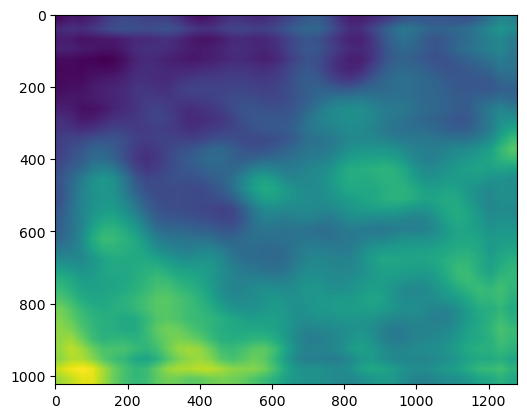

In [30]:
import torch
from tqdm import trange
from utils import naturalSearchProcesswithPath

num_pics = len(input_images) #240 images
IVSN_attention_map, scanpath = {}, {}
IVSN_res = list()

with torch.no_grad():
    for id in range(1):
        stimuli_img, target_img, bbox = input_images[id]
        #Need 3 channels:
        if stimuli_img.shape[0] == 1:
            stimuli_img = torch.cat((stimuli_img, stimuli_img, stimuli_img), 0)
        if target_img.shape[0] == 1:
            target_img = torch.cat((target_img, target_img, target_img), 0)
        
        
        stimuli_batch = stimuli_img.unsqueeze(0)
        target_batch = target_img.unsqueeze(0) 
        
        # Get the output from the model after going through all 30 layers
        stimuli_output = model_ivsn(stimuli_batch)
        target_output = model_ivsn(target_batch)
        
        # Update MMconv weights with target output
        MMconv.weight = torch.nn.Parameter(target_output)
        
        # Get the attention map by applying MMconv to stimuli_output
        attention_IVSN = MMconv(stimuli_output) 
        attention_IVSN = attention_IVSN.squeeze(0)
                
        # Normalize the attention map
        mask_IVSN = transforms.Resize((stimuli_img.shape[1], stimuli_img.shape[2]))(attention_IVSN)
        mask_IVSN = mask_IVSN.squeeze(0)
        mask_IVSN = torch.divide(mask_IVSN, mask_IVSN.max())
                        
        IVSN_attention_map[id] = mask_IVSN.clone().detach() #create deepcopy
        
        IVSN_num, path = naturalSearchProcesswithPath(mask_IVSN, bbox)
        scanpath[id] = path
        IVSN_res.append(IVSN_num)

print(IVSN_res)

plt.imshow(IVSN_attention_map[0])


In [ ]:
#Might need to split up the image into a bunch of images and concatenate -- later